## Kaggle Compettion Submission File
### Matt Johnescu
### Competition: Binary Prediction of Poisonous Mushrooms
#### Primary Challenges:
#### - Data Cleaning
#### - Producing a model with high predictive accuracy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
import joblib
import itertools


# Set random seed and other parameters
SEED = 12
n_splits = 2


In [2]:
# P Comp
'''
train_data = pd.read_csv("C:/Users/johne/Downloads/playground-series-s4e8/train.csv")
test_data = pd.read_csv("C:/Users/johne/Downloads/playground-series-s4e8/test.csv")
'''
# W comp

train_data = pd.read_csv("C:/Users/matt/Downloads/playground-series-s4e8/train.csv")
test_data = pd.read_csv("C:/Users/matt/Downloads/playground-series-s4e8/test.csv")


# Display the first few rows of each dataframe
print(train_data.head())
print(test_data.head())

# Store the 'id' column separately and drop it from the dataset
train_id = train_data['id']
test_id = test_data['id']
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])


   id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y          o       

### Data Exploration

In [3]:
# Function to check basic data statistics, null values, unique values, and data types
def checking(df):
    total = len(df)
    null_df = pd.DataFrame(df.isnull().sum(), columns=['#NULLS'])
    null_df['%NULLS'] = round((null_df['#NULLS'] / total) * 100, 5)
    null_df['#Unique_Values'] = df.nunique()
    null_df['Data_Type'] = df.dtypes  # Adding data type information
    
    cat_cols = [col for col in df.columns if df[col].dtype.name == 'category']
    uniques = []
    for col in df.columns:
        if col in cat_cols:
            uniques.append(set(df[col].dropna()))
        else:
            try:
                uniques.append(df[col].max() - df[col].min())
            except TypeError:
                uniques.append("Not applicable")
    null_df['Unique_Values'] = uniques
    
    return null_df

# Checking the train and test datasets
print("Train Data Overview")
print(checking(train_data))

print("\nTest Data Overview")
print(checking(test_data))




Train Data Overview
                       #NULLS    %NULLS  #Unique_Values Data_Type  \
class                       0   0.00000               2    object   
cap-diameter                4   0.00013            3913   float64   
cap-shape                  40   0.00128              74    object   
cap-surface            671023  21.52823              83    object   
cap-color                  12   0.00038              78    object   
does-bruise-or-bleed        8   0.00026              26    object   
gill-attachment        523936  16.80928              78    object   
gill-spacing          1258435  40.37399              48    object   
gill-color                 57   0.00183              63    object   
stem-height                 0   0.00000            2749   float64   
stem-width                  0   0.00000            5836   float64   
stem-root             2757023  88.45273              38    object   
stem-surface          1980861  63.55136              60    object   
stem-color    

### Notes
 - Stem-root, veil-type, spore-print-color, veil-color

<Figure size 1200x800 with 0 Axes>

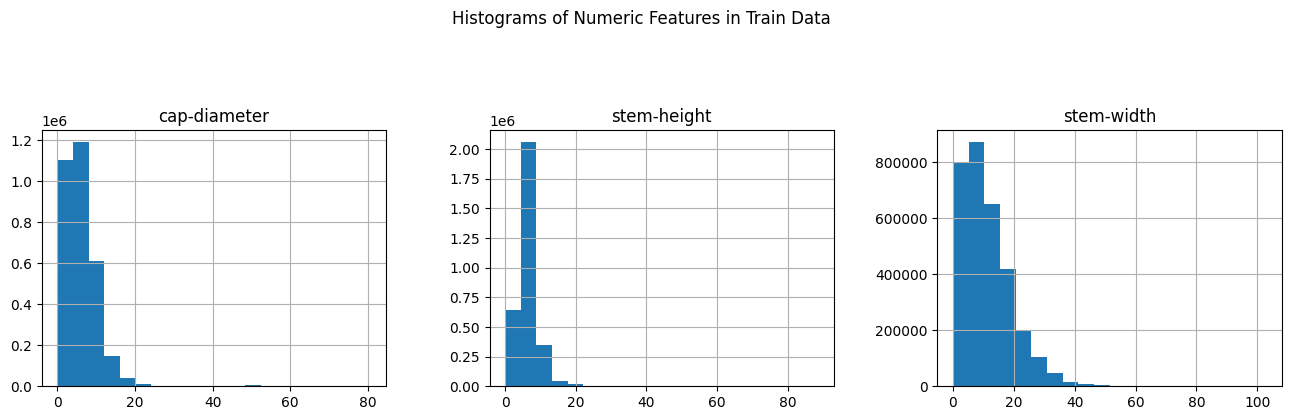

In [4]:
# Histograms of numeric features
numeric_features = train_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
train_data[numeric_features].hist(bins=20, figsize=(16, 12), layout=(3, 3))
plt.suptitle("Histograms of Numeric Features in Train Data")
plt.show()


In [3]:
# Function to detect outliers
def outliers_detection(df, q1_coef=0.25, q3_coef=0.75):
    data_out = df.copy()
    outlier_counts = {}

    num_cols = [col for col in data_out.columns if data_out[col].dtype != 'object']

    for col in num_cols:
        q1 = data_out[col].quantile(q1_coef)
        q3 = data_out[col].quantile(q3_coef)
        iqr = q3 - q1
        outlier_counts[col] = len(data_out[(data_out[col] < q1 - 1.5 * iqr) | (data_out[col] > q3 + 1.5 * iqr)])
    
    return outlier_counts

# Detecting outliers in the training data
outliers = outliers_detection(train_data)
print("Outliers detected in each column:")
print(outliers)


Outliers detected in each column:
{'cap-diameter': 76124, 'stem-height': 132419, 'stem-width': 66481}


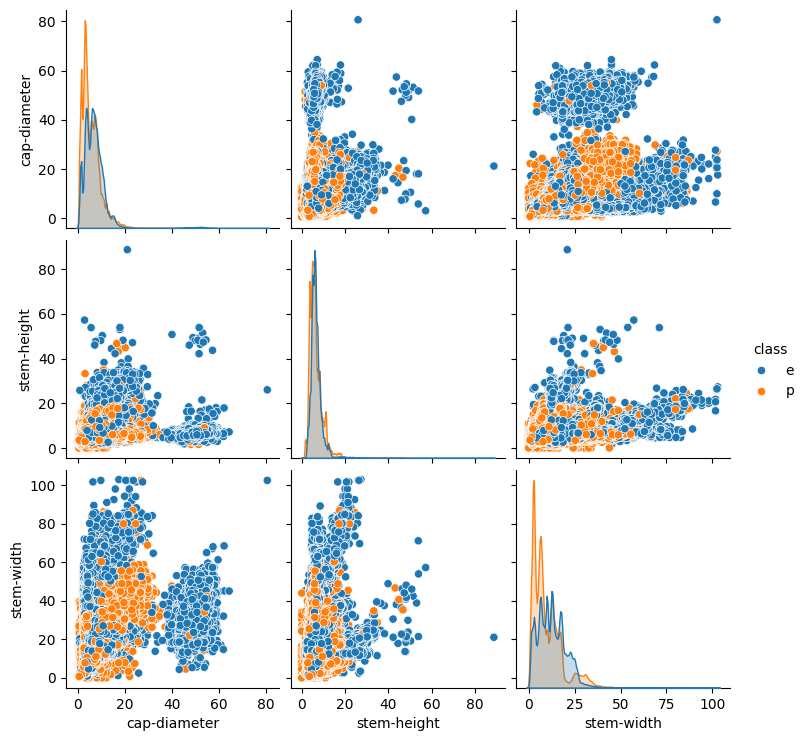

In [6]:
# Pairplot visualization of selected features
selected_features = ['cap-diameter', 'stem-height', 'stem-width', 'class']
sns.pairplot(train_data[selected_features], hue='class')
plt.show()



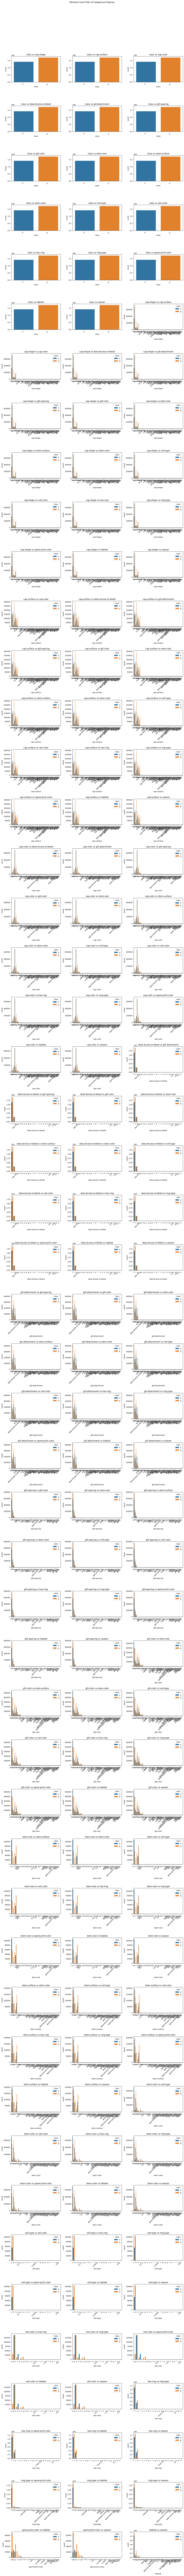

In [7]:
def categorical_pairplot(df, hue=None):
    categorical_features = df.select_dtypes(include=['object']).columns
    feature_pairs = list(itertools.combinations(categorical_features, 2))
    
    n_pairs = len(feature_pairs)
    n_cols = 3
    n_rows = (n_pairs + n_cols - 1) // n_cols  # Calculate rows needed
    
    plt.figure(figsize=(n_cols*5, n_rows*4))
    for i, (x, y) in enumerate(feature_pairs, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.countplot(x=x, hue=hue, data=df)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'{x} vs {y}')
    plt.tight_layout()
    plt.suptitle("Pairwise Count Plots of Categorical Features", y=1.02)
    plt.show()

# Apply the function to train data
categorical_pairplot(train_data, hue='class')

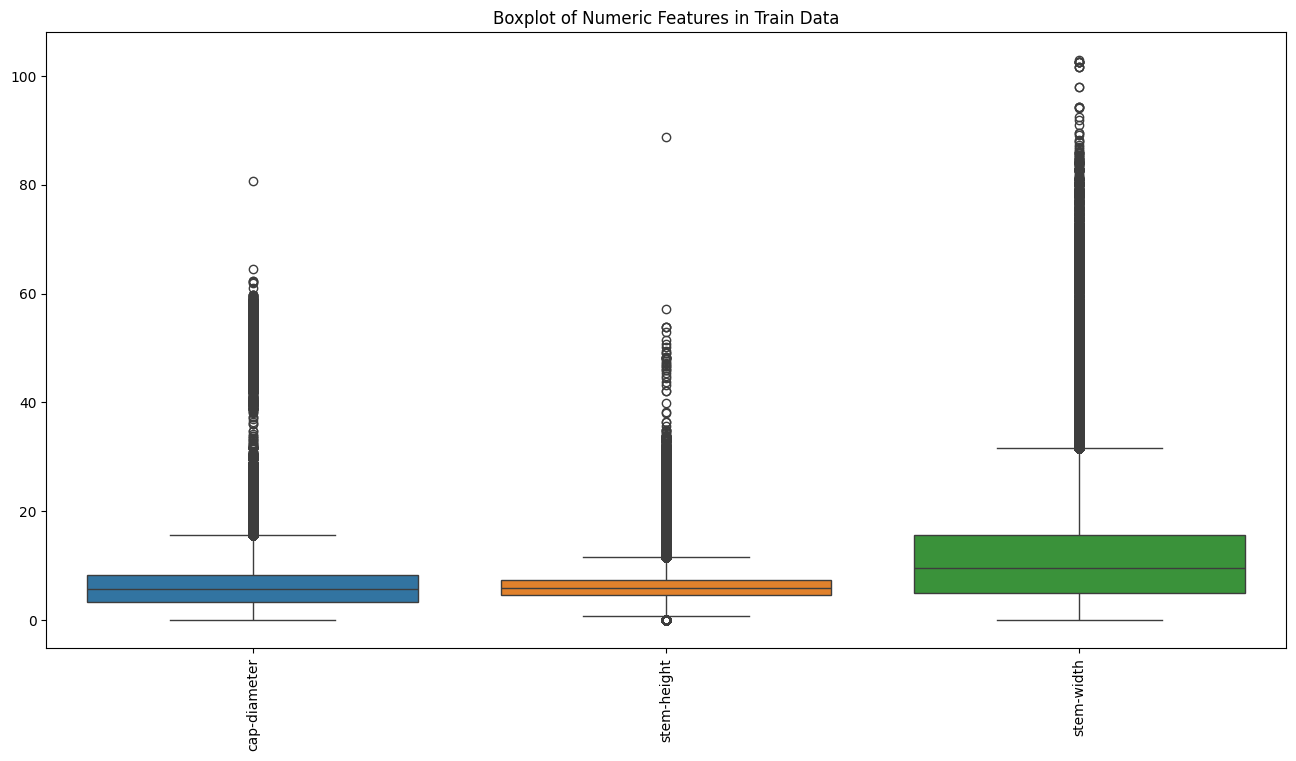

In [8]:
# Boxplot to check for outliers
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_data[numeric_features])
plt.title("Boxplot of Numeric Features in Train Data")
plt.xticks(rotation=90)
plt.show()

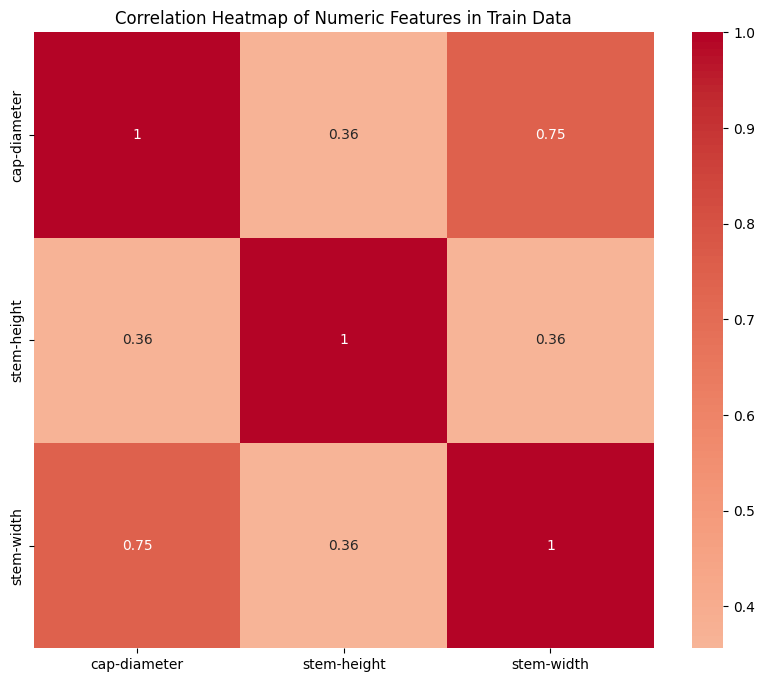

In [9]:
# Correlation heatmap of numeric features
plt.figure(figsize=(10, 8))
corr_matrix = train_data[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numeric Features in Train Data")
plt.show()

C:\Users\matt\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


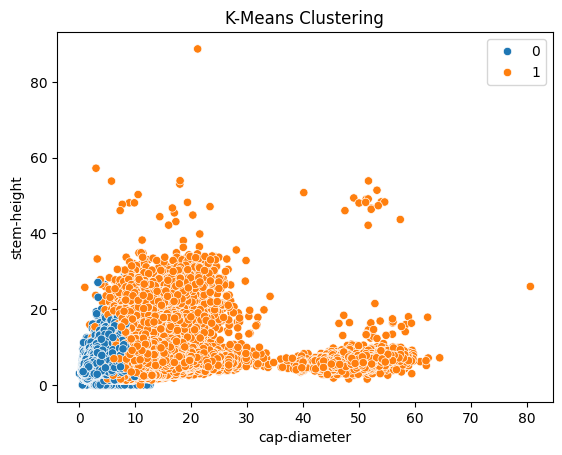

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering with K-Means
features_for_clustering = ['cap-diameter', 'stem-height', 'stem-width']
X = train_data[features_for_clustering].fillna(0)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Visualize clustering results
sns.scatterplot(x='cap-diameter', y='stem-height', hue=kmeans_labels, data=train_data)
plt.title('K-Means Clustering')
plt.show()


### Cleaning and Pre-processing

In [7]:
# After processing, add the 'id' column back to the datasets
train_data['id'] = train_id
test_data['id'] = test_id

# Data Cleaning and Preprocessing
def handle_missing_values(train, test, seed=None):
    num_c = [col for col in train.columns if train[col].dtype in ['float64', 'int64']]
    cat_c = [col for col in train.columns if train[col].dtype == 'object']
    if 'class' in cat_c:
        cat_c.remove('class')
    
    I = IterativeImputer(random_state=seed)
    train[num_c] = I.fit_transform(train[num_c])
    test[num_c] = I.transform(test[num_c])
    
    for col in cat_c:
        train[col].fillna('No_Record', inplace=True)
        if col in test.columns:
            test[col].fillna('No_Record', inplace=True)
    
    return train, test, cat_c

def align_columns(train, test):
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    return train, test




In [8]:
# Apply missing value handling and align train/test columns
train_data, test_data, cat_cols = handle_missing_values(train_data, test_data, seed=SEED)
target = train_data['class']
train_features = train_data.drop(columns=['class'], errors='ignore')
train_features_aligned, test_features_aligned = align_columns(train_features, test_data)

C:\Users\matt\AppData\Local\Temp\ipykernel_4428\289461210.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna('No_Record', inplace=True)
C:\Users\matt\AppData\Local\Temp\ipykernel_4428\289461210.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [9]:
# Encode categorical features
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_features_encoded = encoder.fit_transform(train_features_aligned)
test_features_encoded = encoder.transform(test_features_aligned)

In [15]:
print(X.columns)


Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')


### Setting Up Model

In [32]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Define the features to include
selected_features = ['cap-diameter', 'stem-height', 'stem-width', 'cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-color', 'gill-spacing', 'season', 'habitat', 'ring-type', 'has-ring', 'stem-color']

# Filter the training and testing DataFrames to include only the selected features
train_features_filtered = train_features_aligned[selected_features]
test_features_filtered = test_features_aligned[selected_features]

# Encode the filtered features
train_features_encoded = encoder.fit_transform(train_features_filtered)
test_features_encoded = encoder.transform(test_features_filtered)


# Model Training with XGBoost
def Train_ML(Model, X, y, test_data):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    train_scores = []
    val_scores = []
    test_predictions = [] 
    models = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        model = Model
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_mcc = matthews_corrcoef(y_train, y_train_pred)
        train_scores.append(train_mcc)

        y_val_pred = model.predict(X_val)
        val_mcc = matthews_corrcoef(y_val, y_val_pred)
        val_scores.append(val_mcc)
        
        y_test_pred_proba = model.predict(test_data)
        test_predictions.append(y_test_pred_proba)
        
        models.append(model)

        print(f"Fold {fold}: Train MCC = {train_mcc:.6f}, Validation MCC = {val_mcc:.6f}")

    mean_train_mcc = np.mean(train_scores)
    mean_val_mcc = np.mean(val_scores)
    print(f"\nMean Train MCC: {mean_train_mcc:.6f}")
    print(f"Mean Validation MCC: {mean_val_mcc:.6f}")

    return model, test_predictions



In [33]:
# Set XGBoost parameters
Xparams_s1 = {
    'n_estimators': 1396, 'max_depth': 19, 'learning_rate': 0.010455050159676566, 'subsample': 0.8006842727555243, 
    'colsample_bytree': 0.5001438770455072, 'colsample_bylevel': 0.8027576507794217, 'min_child_weight': 5,
    'reg_alpha': 1.1586967014672253e-08, 'reg_lambda': 3.3517458803447213e-06, 'gamma': 0.01841032988451454
}


In [34]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pandas as pd

# Encode the target variable
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Convert target_encoded to a Pandas Series
target_encoded = pd.Series(target_encoded)

# Initialize the XGBoost model
xgb_model = XGBClassifier(**Xparams_s1, random_state=SEED, tree_method='hist', use_label_encoder=False)

# Now use `target_encoded` instead of `target` in your model training
xgb_model, xgb_preds = Train_ML(xgb_model, pd.DataFrame(train_features_encoded), target_encoded, pd.DataFrame(test_features_encoded))



c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1: Train MCC = 0.986784, Validation MCC = 0.982867


c:\Users\matt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2: Train MCC = 0.986805, Validation MCC = 0.982752

Mean Train MCC: 0.986795
Mean Validation MCC: 0.982809


In [35]:
# Save the trained model
joblib.dump(xgb_model, 'xgb_model_final.pkl')


['xgb_model_final.pkl']

Feature importance scores:
1: 665179.0
0: 618743.0
2: 574060.0
9: 148945.0
4: 134431.0
5: 131275.0
7: 128255.0
3: 108883.0
6: 79581.0
13: 70632.0
10: 67719.0
8: 48074.0
11: 31272.0
12: 18439.0


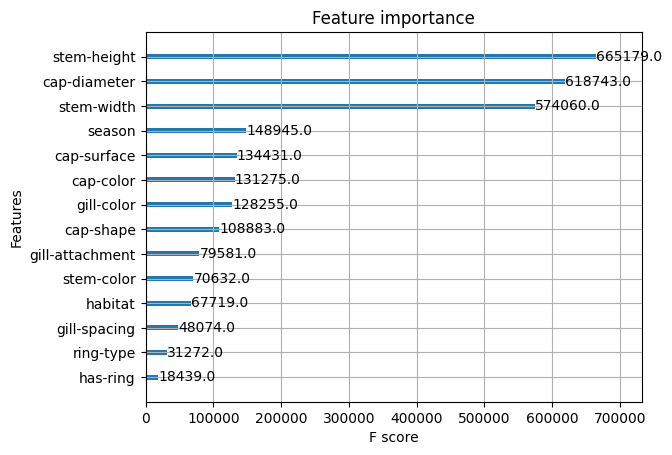

In [36]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Assuming xgb_model is your pre-trained XGBoost model
# Get the feature importance scores
importance_dict = xgb_model.get_booster().get_score(importance_type='weight')

# Check if feature names are available in the model
feature_names = xgb_model.get_booster().feature_names

# If feature names are not available, use the default names
if feature_names is None:
    feature_names = selected_features

# Map the indices or names back to feature names
feature_importance = {}
for k, v in importance_dict.items():
    if k.startswith('f'):  # When keys are 'f0', 'f1', etc.
        index = int(k[1:])  # Extract the integer index
        feature_importance[feature_names[index]] = v
    else:
        feature_importance[k] = v  # When keys are feature names

# Convert the dictionary to a sorted list of tuples for better visualization
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# Print the feature importance scores
print("Feature importance scores:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

# Set the feature names in the booster
xgb_model.get_booster().feature_names = selected_features

# Plot the feature importance using XGBoost's plot_importance function
plot_importance(xgb_model, importance_type='weight')
plt.show()


### Submission

In [37]:
# Averaging predictions over cross-validation folds
xgb_test = np.mean(xgb_preds, axis=0)

# Convert predictions back to original labels
x_f = label_encoder.inverse_transform(xgb_test.astype(int))

# Prepare the submission file
sub_F = pd.DataFrame({
    'id': test_data['id'],
    'class': x_f
})

# Save the submission file
sub_F.to_csv("C:/Users/matt/Downloads/submssion.csv", index=False)

print(sub_F.head())

          id class
0  3116945.0     e
1  3116946.0     p
2  3116947.0     p
3  3116948.0     p
4  3116949.0     e


### Scores: 
#### Score: .982809
 - Params used: selected_features = ['cap-diameter', 'stem-height', 'stem-width', 'cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-color', 'gill-spacing', 'season', 'habitat', 'ring-type', 'has-ring', 'stem-color']


